In [21]:
%pylab inline
import pylab as pl
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import theano

from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

Populating the interactive namespace from numpy and matplotlib


/home/lux/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Define model, train and show first analisises

http://euler.stat.yale.edu/~tba3/stat665/lectures/lec17/notebook17.html#III.-Visualizing-convolution-weights

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [3]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape = (1, 28, 28)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(32, 3, 3, border_mode='same'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
          
rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms)

/home/lux/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 28, 28..., padding="same")`
  app.launch_new_instance()
/home/lux/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/home/lux/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [4]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 9s - loss: 0.4713 - val_loss: 0.1168

In [5]:
print("Test classification rate %0.05f" % model.evaluate(X_test, Y_test, verbose = 1))

y_hat = model.predict_classes(X_test)
print(y_hat)
pd.crosstab(y_hat, y_test)

 9664/10000 [===========================>..] - ETA: 0s[7 2 1 ..., 4 5 6]


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,976,0,3,0,0,1,8,1,5,4
1,0,1128,0,0,3,1,6,4,1,3
2,0,1,1008,3,5,0,0,4,6,0
3,1,5,9,999,0,15,1,1,2,5
4,0,0,0,1,963,0,1,1,2,13
5,0,0,0,3,0,870,7,0,1,6
6,2,0,0,0,1,3,930,0,1,0
7,0,0,8,3,0,0,0,1014,3,7
8,1,1,4,0,2,1,5,0,945,3


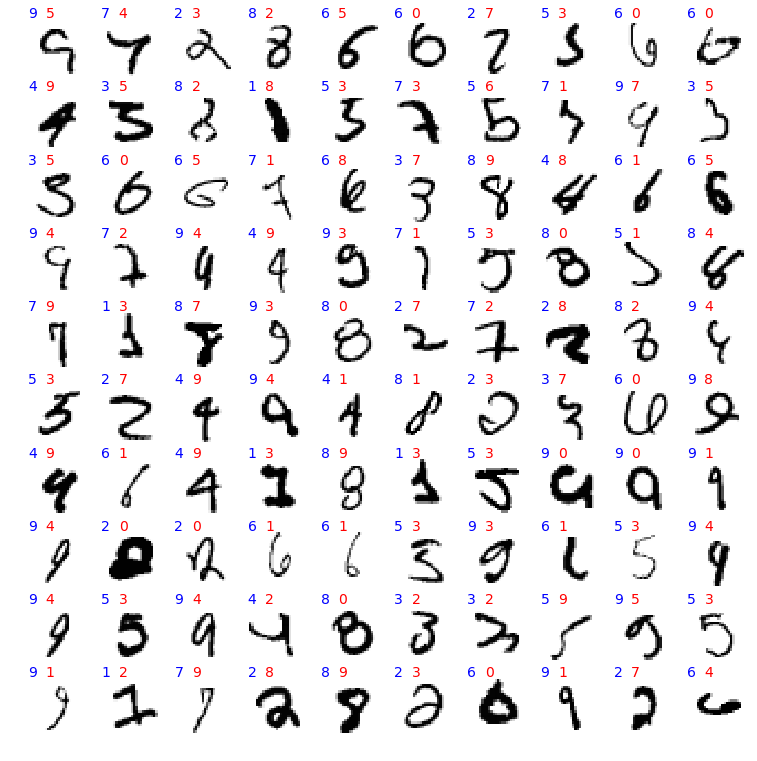

In [6]:
test_wrong = [im for im in zip(X_test,y_hat,y_test) if im[1] != im[2]]

plt.figure(figsize=(10, 10))
for ind, val in enumerate(test_wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0].reshape((28,28))
    plt.axis("off")
    plt.text(0, 0, val[2], fontsize=14, color='blue')
    plt.text(8, 0, val[1], fontsize=14, color='red')
    plt.imshow(im, cmap='gray')

### Visualizing convolution weights

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 28, 32)         8096      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 28, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 28, 32)         9248      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 28, 32)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 14, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 14, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
__________

In [23]:
convout1_f = theano.function(model.inputs, [convout1.output])
convout2_f = theano.function(model.inputs, [convout2.output])

In [24]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

In [19]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

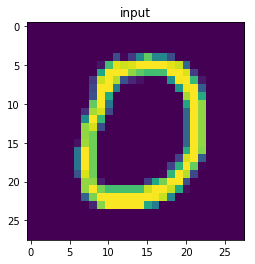

In [9]:
i = 10

# Visualize the first layer of convolutions on an input image
X = X_test[i:i+1]

plt.figure()
plt.title('input')
plt.imshow(np.squeeze(X))

C1 shape :  (28, 32)


IndexError: tuple index out of range

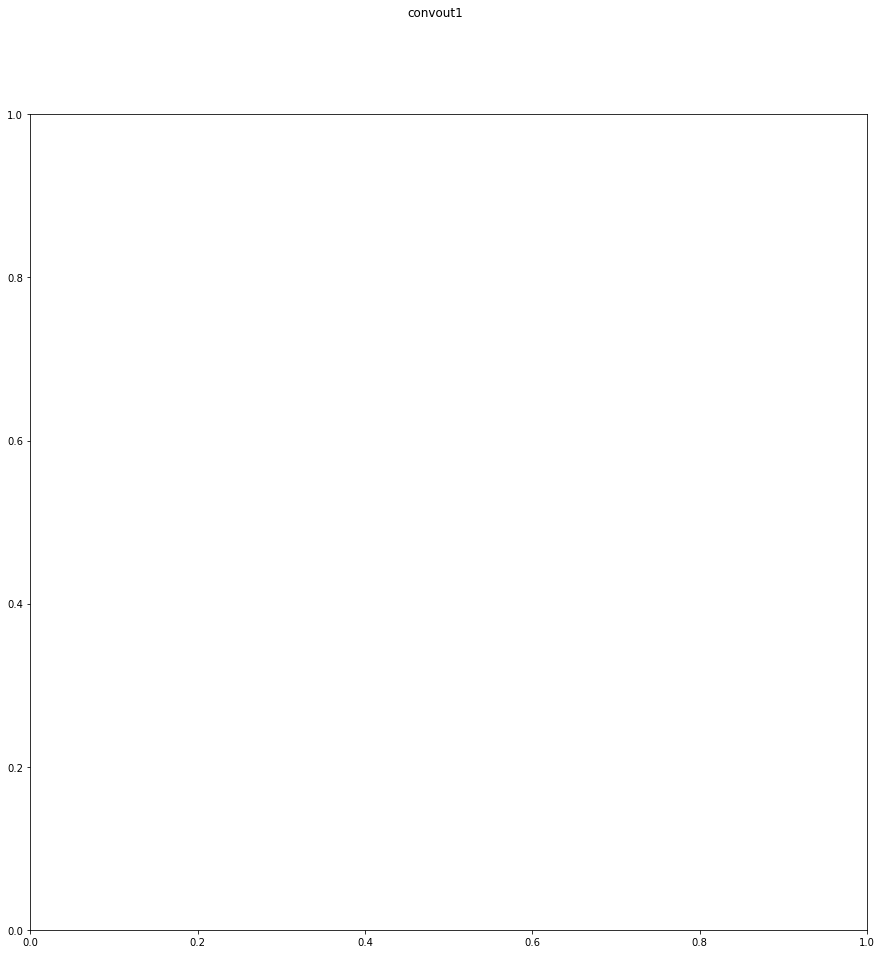

In [25]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

# C1 = C1.reshape(32, 28)

pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)


C1 shape :  (28, 32)


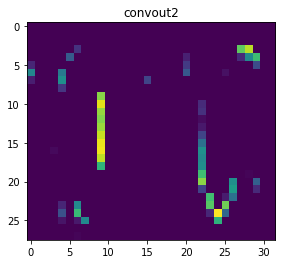

In [17]:
# Visualize convolution result (after activation)
C2 = convout2_f(X)
C2 = np.squeeze(C2)
print("C1 shape : ", C2.shape)

# C1 = C1.reshape(32, 28)

plt.figure()
plt.title('convout2')
plt.imshow(C2)